In [1]:
# preprocessing steps
# Resize images to 224x224
# Standardize the images from 0-1 by scaling with 255
# Split dataset into 24000 train images and 2684 validation images
# Store converted imahes in folders correspindiing to the class 0: no pnemonia, 1: pnemonia
# Compute the mean and standard deviation of the training dataset

# Apply data augmentation to the training dataset
# Randomly flip images horizontally
# Randomly rotate images
# Randomly zoom images
# Randomly shift images horizontally and vertically


# Training:
# Network: ResNet18
## Change input channels from 3 to 1
## change output dimension from 1000 to 1
# Loss: BCEWithLogitsLoss ## Binary Cross Entropy Loss directly applied to logits
## negative output values are converted to 0: no pneumonia, positive values are converted to 1: pneumonia
# Optimizer: Adam(lr=0.0001)
# EPochs: 30

# Interpretability:
# Compute Class activation maps for the images in the validation dataset
# store the last convolutional layer output for the images in the validation dataset known as the feature maps
# extract weights of the last layer
# compute the class activation map for each image
# overlay the class activation map on the original image to visualize the regions of interest
## Note: Only works with CNN
### Alternative GradCAM, GradCAM++, ScoreCAM #! May use these in the future to compare results

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Get Data from Kaggle: https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data
## Unzip data to the DATA directory

# Preprocess

In [2]:
labels = pd.read_csv('../DATA/x_ray_data/stage_2_train_labels.csv')
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [3]:
# Drop deuplicates
labels = labels.drop_duplicates(subset=['patientId'])

In [4]:
ROOT_PATH = Path('../DATA/x_ray_data/stage_2_train_images/')
SAVE_PATH = Path('../DATA/x_ray_data/Processed')

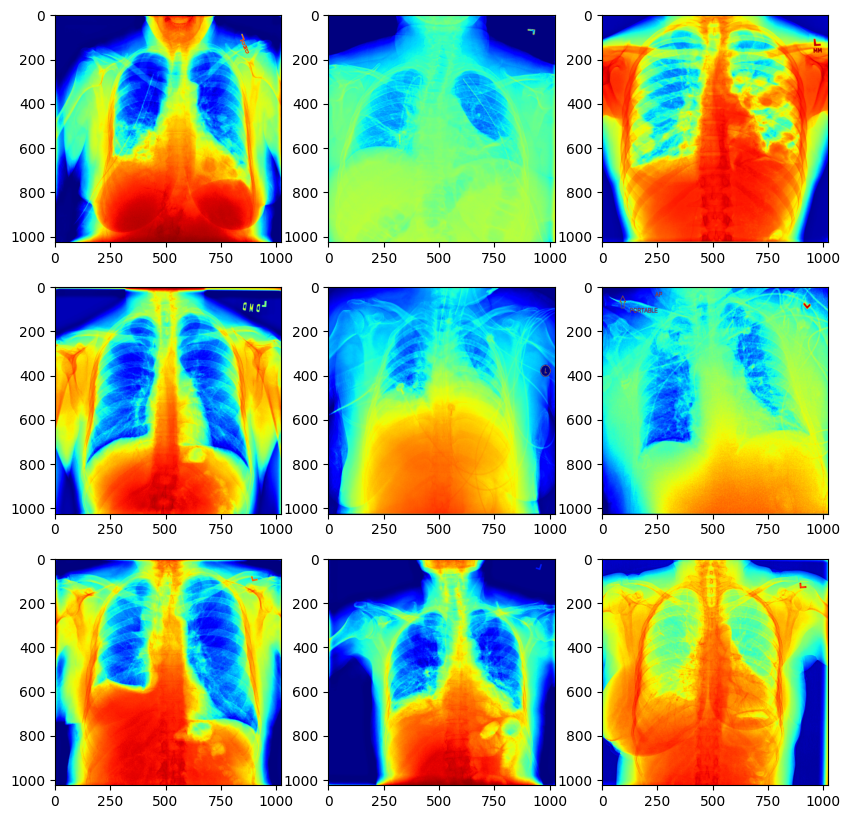

In [5]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
c = 0
for i in range(3):
    for j in range(3):
        img = pydicom.dcmread(ROOT_PATH / f'{labels.iloc[c].patientId}.dcm').pixel_array
        axis[i, j].imshow(img, cmap='jet')
        axis[i, j].axis('on')
        c += 1

## Compute the sum and sum squared for classification model
### equations

In [6]:
sum, sums_squared = 0, 0
for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.iloc[c].patientId
    dcm_path = ROOT_PATH / f'{patient_id}.dcm'
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255 # Standardize the images

    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    label = labels.iloc[c].Target

    train_or_val = "train" if c < 24000 else "val"
    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path / patient_id, dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
        sum += dcm_array.sum() / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
mean = sum / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

# Data Augmentation and Loading

In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(file_path):
    return np.load(file_path).astype(np.float32)

In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.49, std=0.248), # Standardize the images
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)), # Randomly flips image within a range of degrees, shifts image within a range of pixels, scales image within a range of values
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1.)) # Randomly crops and resizes the image
    ])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.49, std=0.248)
])

In [4]:
train_dataset = torchvision.datasets.DatasetFolder('../DATA/x_ray_data/Processed/train', extensions='.npy', transform=train_transforms, loader=load_file)
val_dataset = torchvision.datasets.DatasetFolder('../DATA/x_ray_data/Processed/val', extensions='.npy', transform=val_transforms, loader=load_file)

In [5]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: ../DATA/x_ray_data/Processed/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49, std=0.248)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

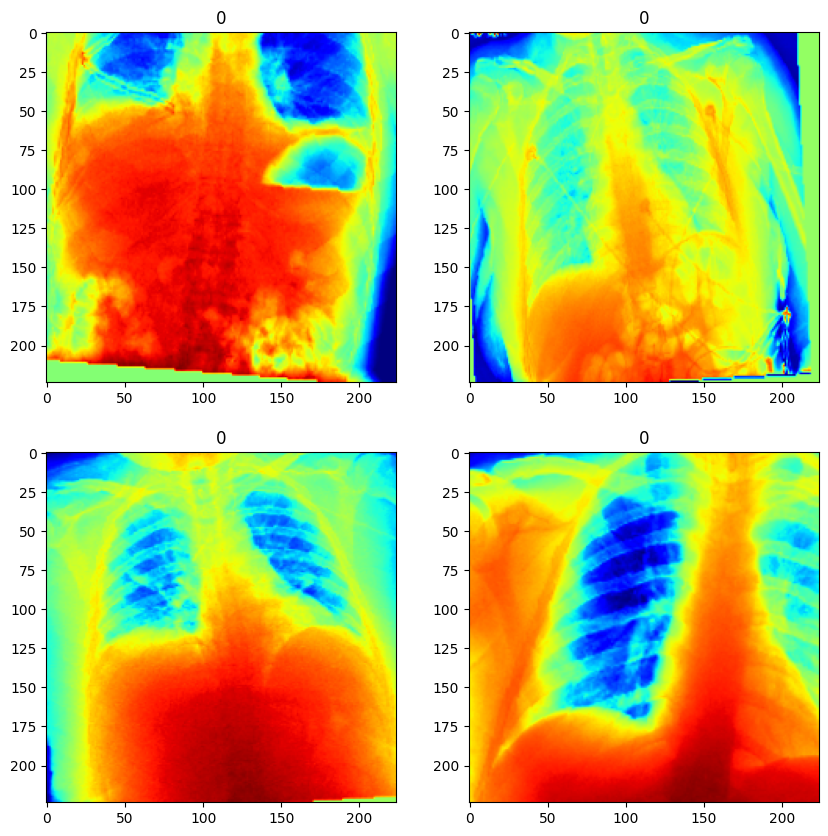

In [6]:
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i, j].imshow(x_ray[0], cmap='jet')
        axis[i, j].set_title(label)

# make dataloaders

In [7]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
# Check if the data loader is working if not this will hang
for batch in train_loader:
    print("Batch loaded successfully!")
    break

Batch loaded successfully!


In [9]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [10]:
# Address imbalanced dataset
# Use weighted loss function to address the imbalance
# Compute the weights for the loss function


In [11]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Training: Adjust the input channels and output dimension of the Resnet18 model
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log('Train Loss', loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label))

        return loss
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        self.train_acc.reset()


    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log('Val Loss', loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label))

        return loss
    
    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        return [self.optimizer]



In [24]:
model = PneumoniaModel()

In [25]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val ACC',
    save_top_k=10,
    mode='max')

In [26]:
# Create Trainer
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=TensorBoardLogger(save_dir='../DATA/x_ray_data/Processed'), log_every_n_steps=1, max_epochs=35, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


# Evaluation

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


model = PneumoniaModel.load_from_checkpoint('../DATA/x_ray_data/Processed/lightning_logs/version_4/checkpoints/epoch=33-step=12750.ckpt')
model.eval()
model.to(device)

cuda:0


PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [31]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [35]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8353204131126404
Val Precision: 0.6159317493438721
Val Recall: 0.715702474117279
Confusion Matrix:
 tensor([[1809,  270],
        [ 172,  433]])
Confusion Matrix 2:
 tensor([[1530,  549],
        [  77,  528]])


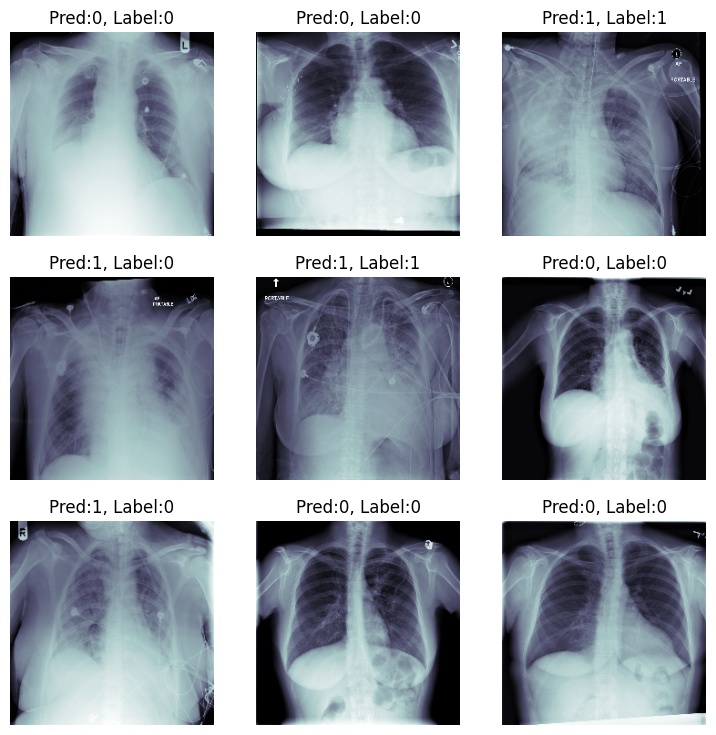

In [41]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")